### Download LJSpeech dataset from https://keithito.com/LJ-Speech-Dataset/ and extract into ../data/
### or...

In [ ]:
# Download LJSpeech Dataset
import requests
import tarfile
import os

# URL for the official tar.bz2 dataset
url = "https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2"
filename = "../data/LJSpeech-1.1.tar.bz2"

# Download with streaming
print("Downloading LJ Speech dataset...")
with requests.get(url, stream=True) as r:
    r.raise_for_status()
    with open(filename, "wb") as f:
        for chunk in r.iter_content(chunk_size=8192):
            f.write(chunk)
print("Download complete!")

# Extract
print("Extracting dataset...")
with tarfile.open(filename, "r:bz2") as tar:
    tar.extractall(path='../data')
print("Extraction complete!")

In [1]:
%load_ext autoreload
%autoreload 2

from importlib import reload
from IPython.display import Audio
import torch
import matplotlib.pyplot as plt

from dataloader import LJSpeechDataset, collate_fn
import utils
from deepspeech2 import DeepSpeech2

2026-03-01 17:03:59,706 - INFO - Loading dataset from ..\data\LJSpeech-1.1\wavs...


Number of samples in the dataset: 13100
Sample text: PRINTING, IN THE ONLY SENSE WITH WHICH WE ARE AT PRESENT CONCERNED, DIFFERS FROM MOST IF NOT FROM ALL THE ARTS AND CRAFTS REPRESENTED IN THE EXHIBITION
Sample audio shape: (212893,)


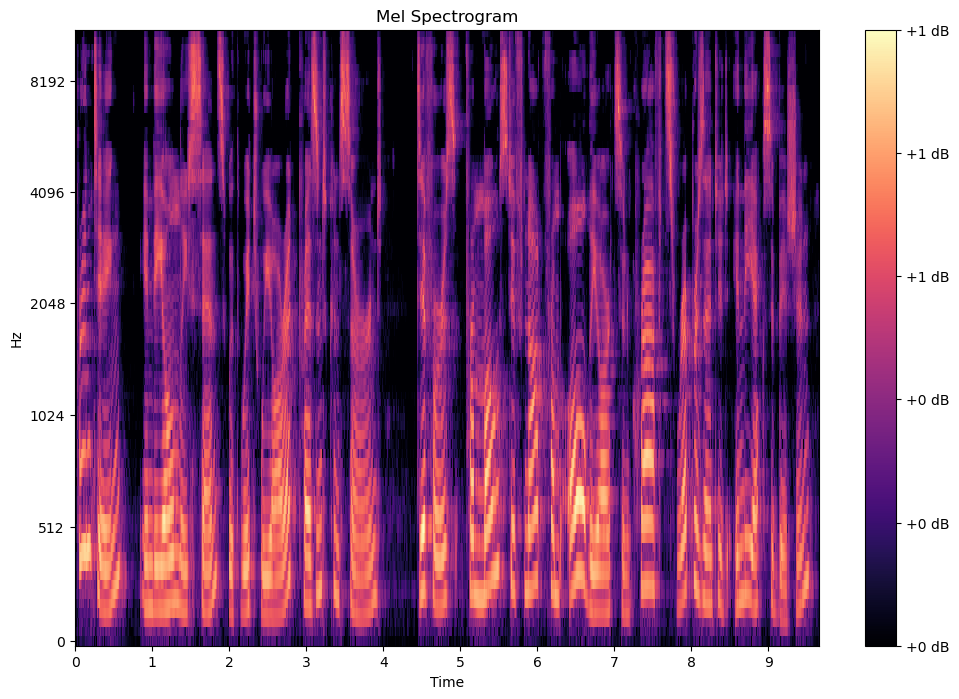

Raw text: PRINTING, IN THE ONLY SENSE WITH WHICH WE ARE AT PRESENT CONCERNED, DIFFERS FROM MOST IF NOT FROM ALL THE ARTS AND CRAFTS REPRESENTED IN THE EXHIBITION
Tokenized text: tensor([23, 13, 10,  9,  6, 10,  9, 21,  3,  4, 10,  9,  4,  6, 11,  5,  4,  8,
         9, 15, 22,  4, 12,  5,  9, 12,  5,  4, 18, 10,  6, 11,  4, 18, 11, 10,
        19, 11,  4, 18,  5,  4,  7, 13,  5,  4,  7,  6,  4, 23, 13,  5, 12,  5,
         9,  6,  4, 19,  8,  9, 19,  5, 13,  9,  5, 14,  3,  4, 14, 10, 20, 20,
         5, 13, 12,  4, 20, 13,  8, 17,  4, 17,  8, 12,  6,  4, 10, 20,  4,  9,
         8,  6,  4, 20, 13,  8, 17,  4,  7, 15, 15,  4,  6, 11,  5,  4,  7, 13,
         6, 12,  4,  7,  9, 14,  4, 19, 13,  7, 20,  6, 12,  4, 13,  5, 23, 13,
         5, 12,  5,  9,  6,  5, 14,  4, 10,  9,  4,  6, 11,  5,  4,  5, 28, 11,
        10, 24, 10,  6, 10,  8,  9])


In [2]:
dataset = LJSpeechDataset("../data/LJSpeech-1.1")
print(f"Number of samples in the dataset: {len(dataset)}")
if len(dataset) > 0:
    sample = dataset[0]
    print(f"Sample text: {sample.raw_text}")
    print(f"Sample audio shape: {sample.raw_audio.shape}")
else:
    print("No samples found in the dataset. Check your data directory and metadata.csv.")

loader = torch.utils.data.DataLoader(dataset, batch_size=8, collate_fn=collate_fn)

utils.plot_audio_mel_spectrogram(sample.mel_audio, sample_rate=sample.sample_rate)
print(f"Raw text: {sample.raw_text}")
print(f"Tokenized text: {sample.tokenized_text}")
Audio(sample.raw_audio, rate=sample.sample_rate)

In [3]:
batch = next(iter(loader))
print(f"Batch size: {len(batch['padded_spectrograms'])}")

print(f"Spectrograms shape: {batch['padded_spectrograms'].shape}")  # Should conform to (batch, channel, n_mels, max_time_frames)
print(f"Input (unpadded) lengths: {batch['input_lengths']}")
print(f"Packed transcripts shape: {batch['packed_transcripts'].shape}")
print(f"Target lengths: {batch['target_lengths']}")

Batch size: 8
Spectrograms shape: torch.Size([8, 1, 80, 833])
Input (unpadded) lengths: tensor([833, 832, 723, 699, 490, 443, 164, 154])
Packed transcripts shape: torch.Size([783])
Target lengths: tensor([155, 151, 116, 143,  74,  89,  30,  25])


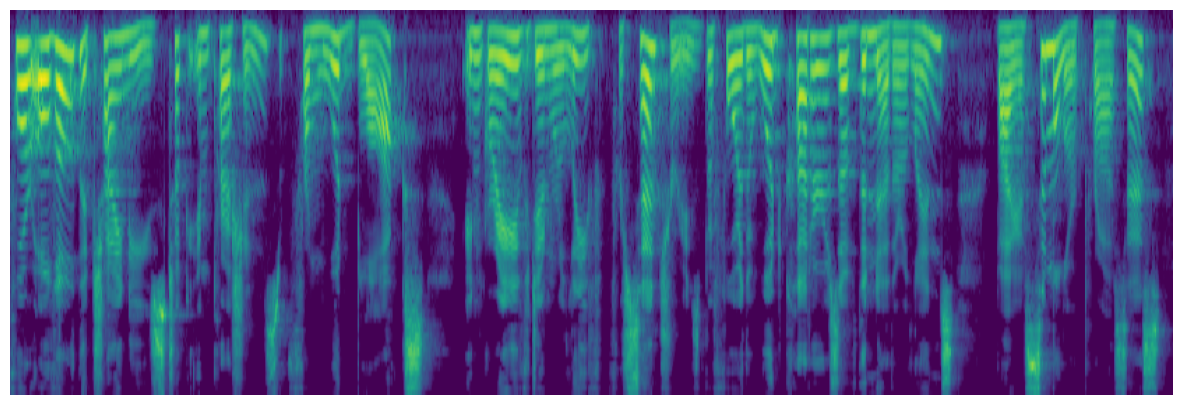

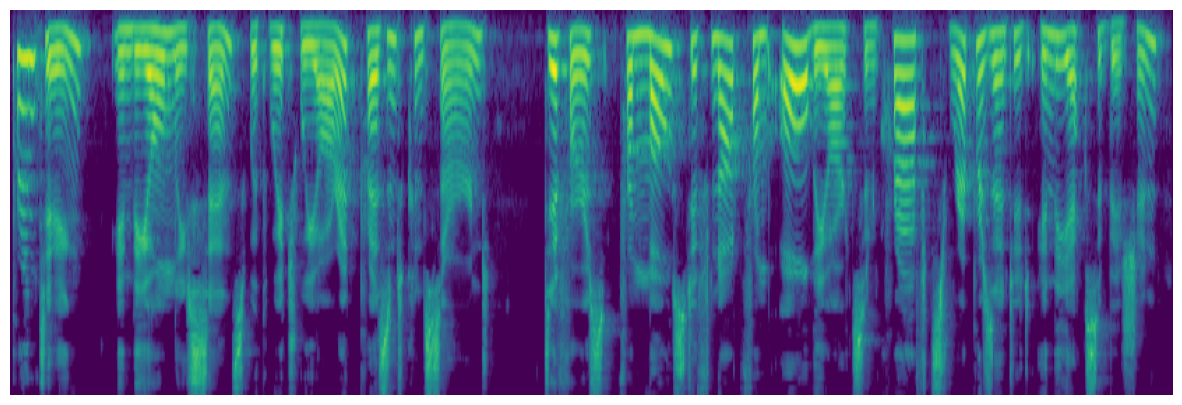

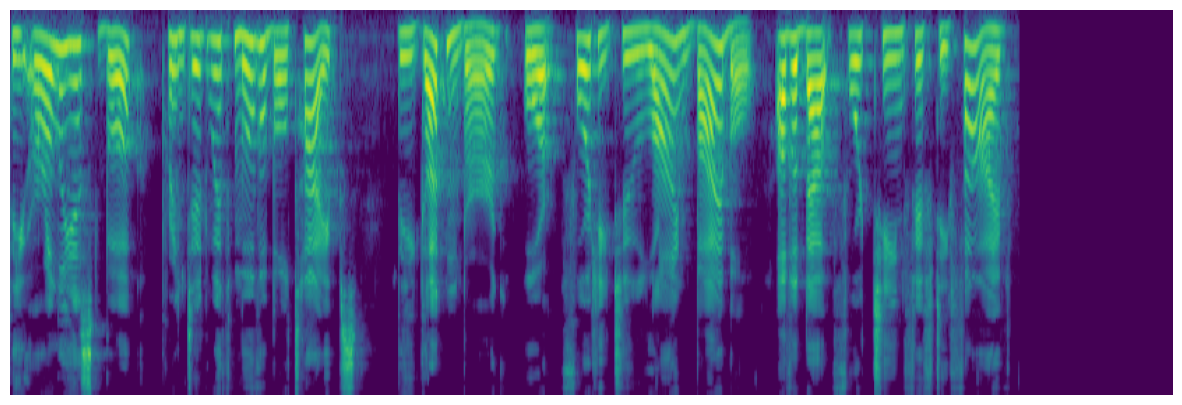

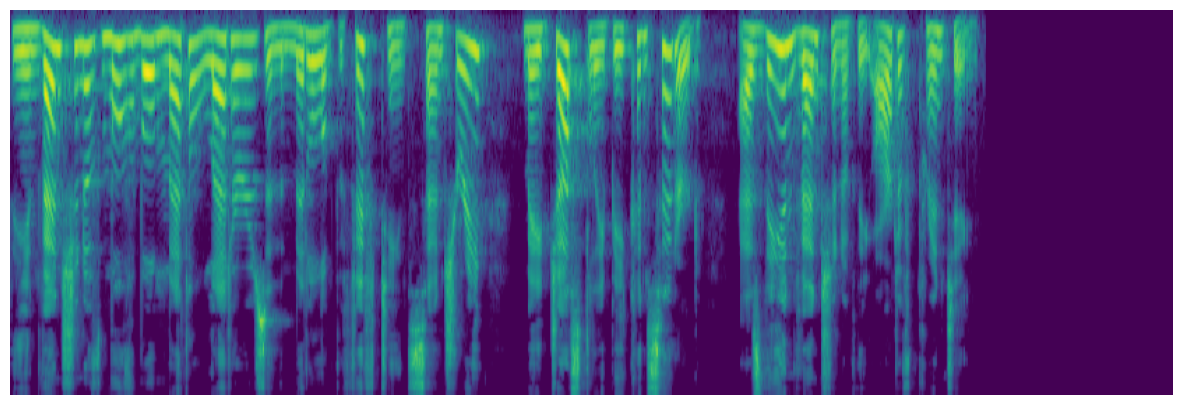

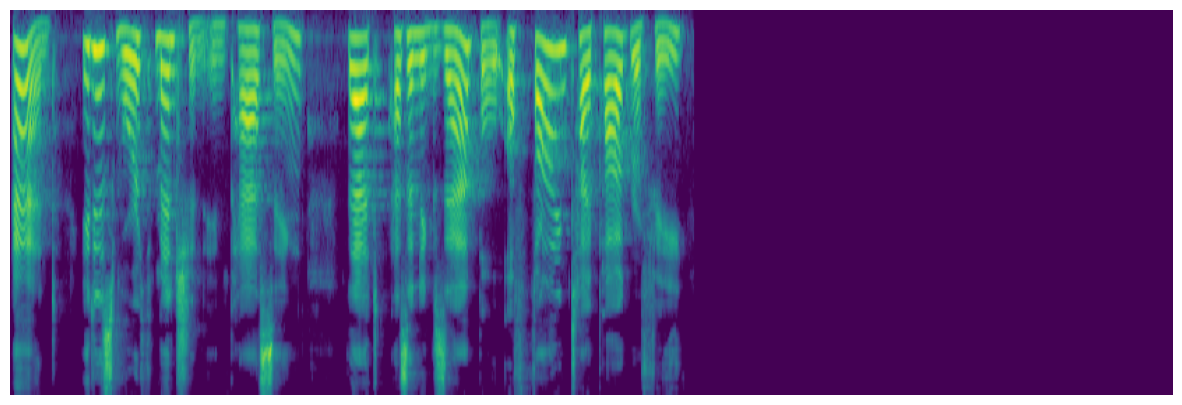

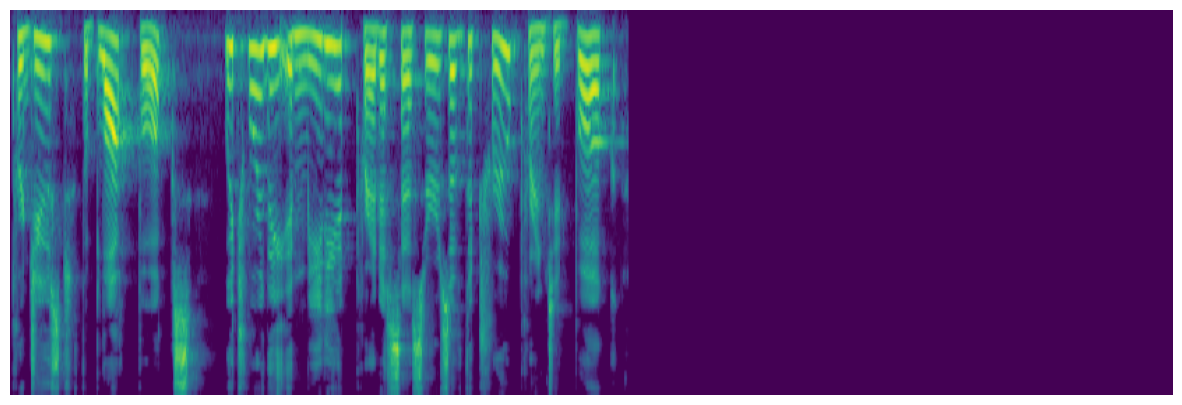

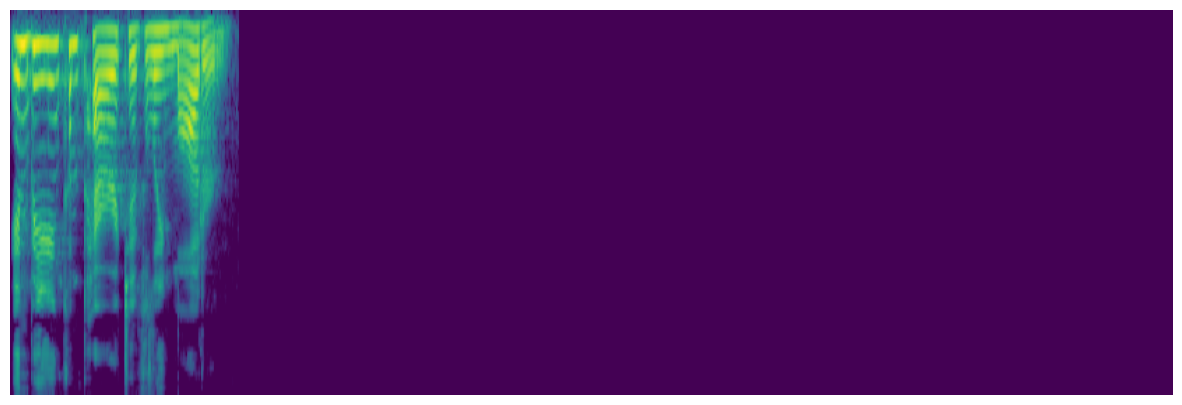

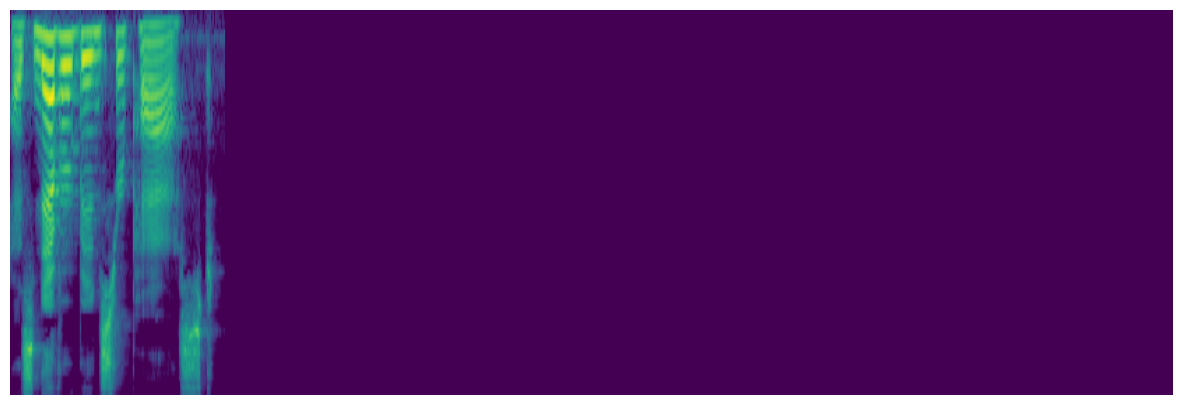

In [4]:
# Confirmation of padding
for data in batch['padded_spectrograms']:
    plt.figure(figsize=(15,5))  
    plt.imshow(data.squeeze(0).numpy(), aspect='auto', origin='lower')
    plt.axis("off")
    plt.gca().invert_yaxis()
    plt.show()

In [ ]:
learningRate = 1e-4
max_epochs = 1

specs = next(iter(loader))['padded_spectrograms']
in_channels = specs.shape[1]

model = DeepSpeech2(conv_in_channels=in_channels)
optimiser = torch.optim.AdamW(params=model.parameters(),
                              lr=learningRate)
utils.train(model=model,
            optimiser=optimiser,
            train_loader=loader,
            loss_fn=model.loss_fn,
            max_epochs=max_epochs)

epoch:   0%|          | 0/1 [00:00<?, ?it/s]

batch:   0%|          | 0/1638 [00:00<?, ?it/s]